In [2]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from numba import njit
from collections import defaultdict
from tqdm.notebook import tqdm

In [3]:
@njit(cache=True)
def availablePositions(board):
    data = np.where(board==0)
    positions = list(zip(data[0], data[1]))
    return positions

In [4]:
@njit('i8[:](i8[:,:],i8, i8, i8)', cache=True)
def who_winner(board, board_rows, board_cols, num_counts):
        # row
        for i in range(board_rows):
            if np.sum(board[i, :]) == num_counts:
                return np.array([1, 1])
            if np.sum(board[i, :]) == -num_counts:
                return np.array([1, -1])
        # col
        for i in range(board_cols):
            if np.sum(board[:, i]) == num_counts:
                return np.array([1, 1])
            if np.sum(board[:, i]) == -num_counts:
                return np.array([1, -1])
        # diagonal
        diag_sum1 = 0
        diag_sum2 = 0
        for i in range(board_cols):
            diag_sum1 += board[i, i]
            diag_sum2 += board[i, board_cols - i - 1]
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == num_counts:
            if diag_sum1 == num_counts or diag_sum2 == num_counts:
                return np.array([1, 1])
            else:
                return np.array([1, -1])

        if len(availablePositions(board)) == 0:
            return np.array([1, 0])
        return np.array([0, 0])

In [5]:
class TicTacToe:
    def __init__(self, board_rows, board_cols, num_counts):
        self.board = np.zeros((board_rows, board_cols), dtype = int)
        self.isEnd = False
        self.playerName = 1
        self.board_rows = board_rows
        self.board_cols = board_cols
        self.num_counts = num_counts

    def updateState(self, position):
        self.board[position] = self.playerName
        self.playerName = -1 if self.playerName == 1 else 1
        self.is_winner()

    def reset(self):
        self.board = np.zeros((self.board_rows, self.board_cols), dtype = int)
        self.isEnd = False
        self.playerName = 1

    def availablePositions(self,):
        return availablePositions(self.board)
    
    def is_winner(self):
        win = who_winner(self.board, self.board_rows, self.board_cols, self.num_counts)
        self.isEnd = win[0]
        if win[0] == 0:
            return None
        return win[1]
    
    def copy_board(self):
        tmp = TicTacToe(board_rows=self.board_rows, board_cols=self.board_cols, num_counts=self.num_counts)
        tmp.board = self.board.copy()
        tmp.isEnd = self.isEnd
        tmp.playerName = self.playerName
        return tmp
        
    def take_available_steps(self):
        boards = []
        if self.isEnd == False:
            for pos in self.availablePositions():
                board = self.copy_board()
                board.updateState(pos)
                boards.append(board)
        return set(boards)
    
    def take_random_step(self):
        if self.isEnd == True:
            return None
        board = self.copy_board()
        av_pos = board.availablePositions()
        board.updateState(random.choice(av_pos))
        return board
    
    def get_hash(self):
        return self.board.tobytes()
    
    def __hash__(self):
        return hash(self.board.tobytes())
    
    def __eq__(self, other):
        return self.get_hash() == other.get_hash()

In [6]:
class MCTS:
    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)
        self.N = defaultdict(int)
        self.children = dict()
        self.exploration_weight = exploration_weight

    def choose(self, node):
        if node not in self.children:
            return node.take_random_step()
        
        def find_score(n):
            if self.N[n] == 0:
                return float("-inf")
            return self.Q[n] / self.N[n]
        
        return max(self.children[node], key=find_score)
    
    def do_rollout(self, node):
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._random_play(leaf)
        self._backpropagate(path, reward)
    
    def _select(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                return path
            for n in self.children[node]:
                if n not in self.children:
                    path.append(n)
                    return path
            node = self._uct_select(node)

    def _expand(self, node):
        if node in self.children:
            return
        self.children[node] = node.take_available_steps()

    def _random_play(self, node):
        while node.isEnd == False:
            node = node.take_random_step()
        return node.is_winner()

    def _backpropagate(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
    
    def _uct_select(self, node):
        assert all(n in self.children for n in self.children[node])
        if node.playerName == -1:
            return node.take_random_step()
        metric = math.log(self.N[node])
        
        def uct(n):
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(metric / self.N[n])
        
        return max(self.children[node], key=uct)

In [7]:
def one_episode(game, tree, do_learning=True, rollouts=50):
    game.reset()
    while game.isEnd == False:
        if do_learning:
            for _ in range(rollouts):
                tree.do_rollout(game)
        game = tree.choose(game)
        if game.isEnd == False:
            game = game.take_random_step()
    return game.is_winner()

In [8]:
def run(size_field = 3, episod_fit = 10000, episod_validate=10000, delta_validate = 1000):
    dict_data = {-1:[], 0:[], 1:[]}
    mean_data = []
    data_x = []
    
    game = TicTacToe(size_field, size_field, size_field)
    mcts=MCTS(exploration_weight=0.8)
    
    for i in tqdm(range(episod_fit + 1)):
        one_episode(game, mcts)
        if i % delta_validate == 0:
            counts = 0
            dict_res = {-1:0, 0:0, 1:0}
            for j in range(episod_validate):
                res = one_episode(game, mcts, do_learning=False)
                dict_res[res] += 1
                counts += res
            data_x.append(i)
            mean_data.append(counts/episod_validate)
            dict_data[1].append(dict_res[1])
            dict_data[0].append(dict_res[0])
            dict_data[-1].append(dict_res[-1])
            print("Rounds {}, mean ={}, win = {}, draw = {}, loose = {}".format(i, 
                                                                                counts/episod_validate, 
                                                                                dict_res[1],
                                                                                dict_res[0],
                                                                                dict_res[-1]))
    return data_x, mean_data, dict_data

In [9]:
def draw_plot(fig, ax, data_x, data_y, data_y1, data_y2, data_y3):
        '''Отрисовка значений среднего выигрыша'''
        ax[0].clear()
        ax[0].plot(data_x, data_y)
        ax[0].set_title('Зависимость среднего выигрыша от итерации обучения')
        ax[0].set_ylabel('Средний выигрыш')
        ax[0].set_xlabel('Итерация обучения')
        ax[0].grid()
        
        ax[1].clear()
        ax[1].plot(data_x, data_y1, label="Выигрыш")
        ax[1].plot(data_x, data_y2, label="Ничья")
        ax[1].plot(data_x, data_y3, label="Поражение")
        ax[1].legend(loc='best', bbox_to_anchor=(0.95, 0.1, 0.05, 0.3))
        
        ax[1].set_title('Зависимость числа исходов событий для стратегии "X" от итерации обучения')
        ax[1].set_ylabel('Число игр')
        ax[1].set_xlabel('Итерация обучения')
        ax[1].grid()
        
        fig.canvas.draw()

# Игра 4х4

In [9]:
data_x, mean_data, dict_data = run(size_field = 4, episod_fit = 12000, episod_validate=10000, delta_validate = 250)

Rounds 0, mean =0.1056, win = 3480, draw = 4096, loose = 2424
Rounds 250, mean =0.3114, win = 4905, draw = 3304, loose = 1791
Rounds 500, mean =0.5784, win = 6885, draw = 2014, loose = 1101
Rounds 750, mean =0.7553, win = 8132, draw = 1289, loose = 579
Rounds 1000, mean =0.8113, win = 8539, draw = 1035, loose = 426
Rounds 1250, mean =0.8346, win = 8705, draw = 936, loose = 359
Rounds 1500, mean =0.8403, win = 8751, draw = 901, loose = 348
Rounds 1750, mean =0.8564, win = 8877, draw = 810, loose = 313
Rounds 2000, mean =0.876, win = 9002, draw = 756, loose = 242
Rounds 2250, mean =0.8868, win = 9106, draw = 656, loose = 238
Rounds 2500, mean =0.901, win = 9208, draw = 594, loose = 198
Rounds 2750, mean =0.904, win = 9229, draw = 582, loose = 189
Rounds 3000, mean =0.9068, win = 9237, draw = 594, loose = 169
Rounds 3250, mean =0.9226, win = 9353, draw = 520, loose = 127
Rounds 3500, mean =0.9222, win = 9341, draw = 540, loose = 119
Rounds 3750, mean =0.9295, win = 9422, draw = 451, loose

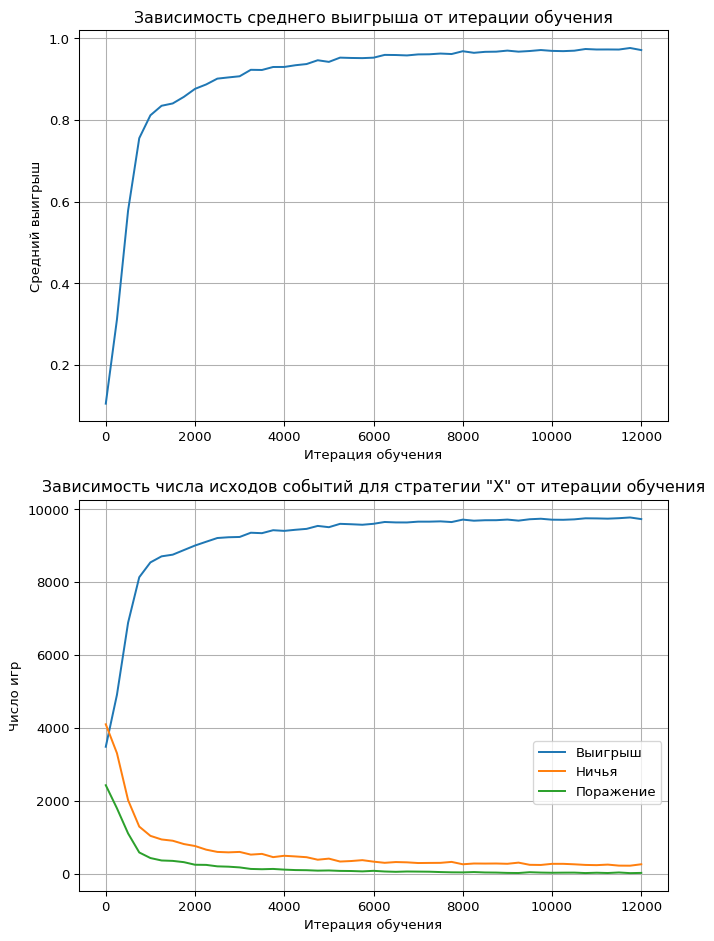

In [10]:
fig, ax = plt.subplots(nrows=2, figsize=(8,12), dpi=95);
draw_plot(fig, ax, data_x, mean_data, dict_data[1], dict_data[0], dict_data[-1])

# Игра 5х5

In [ ]:
data_x, mean_data, dict_data = run(size_field = 5, episod_fit = 25000, episod_validate=10000, delta_validate = 1000)

Rounds 0, mean =0.1209, win = 2631, draw = 5947, loose = 1422
Rounds 1000, mean =0.2055, win = 3242, draw = 5571, loose = 1187
Rounds 2000, mean =0.2353, win = 3469, draw = 5415, loose = 1116
Rounds 3000, mean =0.2461, win = 3515, draw = 5431, loose = 1054


In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(8,12), dpi=95);
draw_plot(fig, ax, data_x, mean_data, dict_data[1], dict_data[0], dict_data[-1])

Обучение 5х5, прошло неудачно, так как код был написан неоптимально и не хватило оперативной памяти